# Semester Project: Data Analysis
_By Ali AMIN_

In this Notebook, we are going to perform some analysis over a given data collected from an experiment done by a team from a brazilian university. The experiment goal is to analyze <b>the impact of video quality disturbance</b>, that may affect any user who's watching, <b>on the content preference.</b>

### How the experiment works?

In this experiment the user will watch 4 video sessions based on user's categories preference that was choosen before starting. In First session, you will watch a video including some interuptions and then watch it again with a high quality. The goal from this session is to figure out user's <b>Stress</b> tolerance with such interruptions. In the next 3 session, you will watch two videos in each session related to the same category, one with more interesting content and some interuptions and another with less interest and high quality. After finishing each session the user should decide <b>the preferred video</b> out of them.

There was 7 video categories and 3 were shown to the user randomly or depending on user's preference. The categories are: 

Video ID | Category
---------|----------
1| Sport
2| Series
3| Animals
4| Entertaiment
5| Documentary
6| Science
7| Music


#### The collected data are:


* <b>Stress Level</b>: Users stress level, out of 10, resulted from iteruptions.
* <b>Interest of the content</b>: The quality of content for both videos in the same session, out of 5, regardless of the interuptions
* <b>Prefered Video</b> : Users favorite video after watching both of them, in each session.
* <b>Annoyance</b> : Users reaction with iterruption from the low quality video
* <b>Comments</b> : 
             1. Why did you prefer this video?
             2. Comments on the session 

</div>

## Our Goal:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql.types import *
from pyspark.sql.functions import explode, split, desc, col, udf, round, when, stddev_pop
%matplotlib inline

import matplotlib.colors as mcolors
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
#Read the data collected
qos_data = pd.read_csv('QoS.csv')

# Removing unused columns 
qos_data_init = qos_data.drop(qos_data.columns[[0, 2, 3, 4, 5, 9, 10, 11, 12, 13, 15, 16]], axis=1) 

#  data information and showing the first 5 rows from it 
print(qos_data_init.info())
qos_data_init.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031 entries, 0 to 1030
Data columns (total 7 columns):
Session            1031 non-null int64
Annoyance          1031 non-null int64
intLowQoS          1031 non-null int64
intHighQoS         1031 non-null int64
Preferred_video    1031 non-null int64
Stress             1031 non-null int64
Dif_interests      1031 non-null int64
dtypes: int64(7)
memory usage: 56.5 KB
None


,Session,Annoyance,intLowQoS,intHighQoS,Preferred_video,Stress,Dif_interests
0,1,1,3,1,1,7,2
1,6,3,5,3,1,7,2
2,2,4,4,1,1,7,3
3,5,3,4,4,2,7,0
4,1,5,2,2,2,10,0


In [21]:
# Sorting data according to each Session
qos_data = qos_data_init.sort_values(by=['Session'],ascending=[True],axis=0)

# Data statistics per session
qos_data_stats = qos_data.groupby("Session").describe().T

# Saving statistics into a separate CSV file
stats = qos_data.groupby("Session").describe()
stats.to_csv('./Statistics1.csv')

In [75]:
# Show Stats related to each session
#for example prefered video
qos_data_stats.loc["Preferred_video"]

Session,1,2,3,4,5,6,7
count,155.000000,124.000000,141.000000,159.000000,141.000000,146.000000,165.000000
mean,1.554839,1.661290,1.460993,1.534591,1.716312,1.390411,1.606061
std,0.511452,0.475191,0.500253,0.500378,0.452394,0.489522,0.490109
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


             mean      mean
Session                    
1        2.451613  3.154839
2        2.895161  3.258065
3        2.134752  2.943262
4        2.509434  3.144654
5        3.042553  3.078014
6        3.034247  3.945205
7        3.181818  3.545455


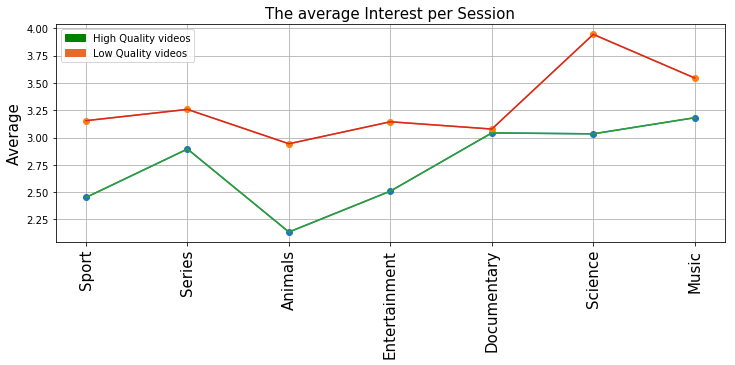

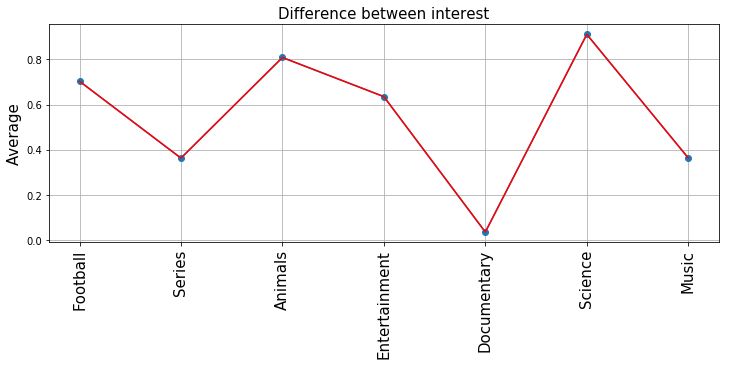

In [33]:
# Collecting means

Annoy_mean = qos_data_stats.loc['Annoyance'].loc['mean']
Dif_LH_mean = qos_data_stats.loc['Dif_interests'].loc['mean']
HQ_mean = qos_data_stats.loc['intHighQoS'].loc['mean']
LQ_mean = qos_data_stats.loc['intLowQoS'].loc['mean']
Stress_mean = qos_data_stats.loc['Stress'].loc['mean']
Fav_mean = qos_data_stats.loc['Preferred_video'].loc['mean']

# Collecting Standard deviations 
Annoy_std = qos_data_stats.loc['Annoyance'].loc['std']
Dif_LH_std = qos_data_stats.loc['Dif_interests'].loc['std']
HQ_std = qos_data_stats.loc['intHighQoS'].loc['std']
LQ_std = qos_data_stats.loc['intLowQoS'].loc['std']
Stress_std = qos_data_stats.loc['Stress'].loc['std']
Fav_std = qos_data_stats.loc['Preferred_video'].loc['std']

# Adding them to LIST
list_of_series_Mean = [ HQ_mean, LQ_mean]
list_of_series_Std= [ HQ_std, LQ_std]

# Converting to Pandas dataframe format
Mean = pd.DataFrame(list_of_series_Mean).T
Std = pd.DataFrame(list_of_series_Std).T


print(Mean)

plt.figure(figsize = (12,4))
plt.grid(True)
plt.title("The average Interest per Session",fontsize = 15)
# plt.xlabel("Sessions",fontsize = 15)
plt.ylabel("Average",fontsize = 15)
plt.plot(Mean["mean"] ,'-o')
plt.xticks(np.arange(1,8),['Sport', 'Series', 'Animals', 'Entertainment', 'Documentary', 'Science', 'Music'],fontsize=15,rotation='vertical')
dr_patch = mpatches.Patch(color='g', label='High Quality videos')
nf_patch = mpatches.Patch(color=[0.9100 ,   0.4100 ,   0.1700], label='Low Quality videos')
plt.legend(handles=[dr_patch,nf_patch])
plt.plot(Mean)



plt.figure(figsize = (12,4))
plt.grid(True)
plt.title("Difference between interest",fontsize = 15)
# plt.xlabel("Sessions",fontsize = 15)
plt.ylabel("Average",fontsize = 15)
plt.plot(Dif_LH_mean ,'-o')


plt.xticks(np.arange(1,8),['Football', 'Series', 'Animals', 'Entertainment', 'Documentary', 'Science', 'Music'],fontsize=15,rotation='vertical')
plt.plot(Dif_LH_mean, color = 'r')

### INTERPRETATION:


<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue "> 


In the first figure, we have plotted both the High quality mean average rating and the same for low quality. As we know, we have 7 different categories and the results showed that in Documentaries the users can accept high QoS but low QoE. For Music and series, the difference is small but still users  prefer. However, for sport, animals and scientific related videos, the results shows a clear win for QoE over QoS.
<br>
<br>
In the second figure, we have plotted the difference between this averages to make the image more clearer.
</div>


In [29]:
Std

,std,std
Session,,
1,1.612426,1.604142
2,1.518550,1.324386
3,1.512896,1.515506
4,1.363484,1.358687
5,1.487435,1.399341
6,1.425939,1.236128
7,1.389300,1.217026


By visualising the Mean average of the 

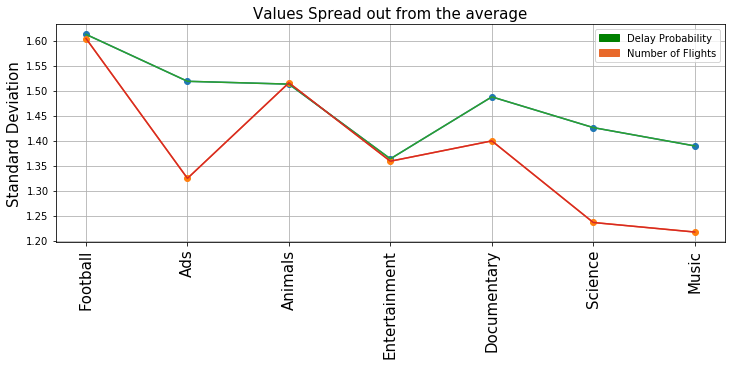

In [32]:
plt.figure(figsize = (12,4))
plt.grid(True)
plt.title("Values Spread out from the average",fontsize = 15)
plt.ylabel("Standard Deviation",fontsize = 15)
plt.plot(Std["std"] ,'-o')
plt.xticks(np.arange(1,8),['Football', 'Ads', 'Animals', 'Entertainment', 'Documentary', 'Science', 'Music'],fontsize=15,rotation='vertical')

dr_patch = mpatches.Patch(color='g', label='High Quality videos')
nf_patch = mpatches.Patch(color=[0.9100 ,   0.4100 ,   0.1700], label='Low Quality videos')
plt.legend(handles=[dr_patch,nf_patch])

plt.plot(Std)


### INTERPRETATION:


<div class="alert alert-success" style="background-color: AliceBlue; border-color: CornflowerBlue "> 


<b>Standard deviation</b> is a number used to tell how measurements for a group are spread out from the average (mean), or expected value. As we can see, for Music and science the standard  deviation average is very small which means that the rating values are quite close to the average, and by this, user feedback is very similar on this categories. However, for sport it's the highest, which means users have distinct perspective regarding this category.
</div>

In [35]:
# df = qos_data_init.groupby("Preferred_video").count().T
# df1 = pd.DataFrame({'lab':['1', '2']}, 'val':[df.loc["Session"]]})
# df1

# plt.figure(figsize = (14,10))
# plt.grid(True, axis='y', linestyle='--',alpha = 0.5,linewidth=2)
# plt.title("Percentage of delayed flights per each hour of the day",fontsize=15)
# plt.xlabel("Hour of the Day",fontsize=15)
# plt.ylabel("Percentage of delayed flights",fontsize=15)
# # plt.xticks(np.arange(0,24),fontsize=15)
# plt.bar(df1['lab'], df.loc["Session"])
# # ,df.loc["Session",2])


In [67]:
# Counting how many time each rate score was submitted: 0,1,2,3,4,5

df = qos_data_init.groupby("intHighQoS").count().T

List=[]

for i in range(0,6):
    num = df.loc['Session'][i]
    List.append(num)

List = pd.DataFrame(List,columns = ['Total Number'])
Session = [0,1,2,3,4,5]
Session = pd.DataFrame(Session,columns = ['Rate score'])

Table = Session.join(List)
Table

,Rate score,Total Number
0,1,88
1,2,156
2,3,189
3,4,242
4,5,204
5,6,152


A trade of between QoE and QoS can be noticed.

In [68]:
# Counting how many time each rate score was submitted: 0,1,2,3,4,5

df = qos_data_init.groupby("intLowQoS").count().T

List=[]

for i in range(0,6):
    num = df.loc['Session'][i]
    List.append(num)

List = pd.DataFrame(List,columns = ['Total Number'])
Session = [0,1,2,3,4,5]
Session = pd.DataFrame(Session,columns = ['Rate score'])

Table = Session.join(List)
Table

,Rate score,Total Number
0,0,48
1,1,91
2,2,130
3,3,230
4,4,298
5,5,234


Here we can see how important is the QoE for the users. Although there was interuption but still the rating scores are high.

In [74]:
# Counting how many time each stress score was submitted: 0,1,2,3,4,5

df = qos_data_init.groupby("Stress").count().T
List=[]

for i in range(0,10):
    num = df.loc['Session'][i]
    List.append(num)

List = pd.DataFrame(List,columns = ['Total Number'])
Session = [1,2,3,4,5,6,7,8,9,10]
Session = pd.DataFrame(Session,columns = ['Stress Level'])

Table = Session.join(List)
Table

,Stress Level,Total Number
0,1,18
1,2,27
2,3,30
3,4,47
4,5,47
5,6,102
6,7,86
7,8,158
8,9,265
9,10,141


Mostly, the users stress level from interuption is quite high if we look at the values from 8 till 10 

In [73]:
# Counting how many time each Annoyance score was submitted: 0,1,2,3,4,5


df = qos_data_init.groupby("Annoyance").count().T

List=[]

for i in range(0,6):
    num = df.loc['Session'][i]
    List.append(num)

List = pd.DataFrame(List,columns = ['Total Number'])
Session = [0,1,2,3,4,5]
Session = pd.DataFrame(Session,columns = ['Rate score'])

Table = Session.join(List)
Table

,Rate score,Total Number
0,0,28
1,1,54
2,2,144
3,3,216
4,4,280
5,5,309


Users showed high sensitivity regarding the quality of service.